In [2]:
import requests
from io import BytesIO
from PIL import Image

import torch
from torchvision import transforms

In [9]:
#device = (
#    torch.device("mps") if torch.backends.mps.is_available()
#    else torch.device("cuda") if torch.cuda.is_available()
#    else torch.device("cpu")
#)  # Disable, MPS does not work with some operation at the moment
device = torch.device("gpu") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [10]:
model = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
for p in model.parameters():
    p.requires_grad = False
model.eval()
model.to(device)
print("Model loaded")

Using cache found in /Users/maparla/.cache/torch/hub/facebookresearch_dino_main


Model loaded


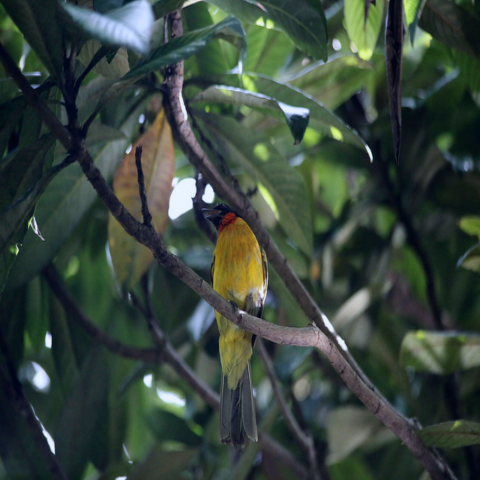

In [21]:
response = requests.get("https://dl.fbaipublicfiles.com/dino/img.png")
img = Image.open(BytesIO(response.content))
img = img.convert('RGB')
img

In [22]:
image_size = (448, 448)
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
img = transform(img)

# make the image divisible by the patch size
patch_size = 16
w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
img = img[:, :w, :h].unsqueeze(0)

# calculate the number of patches
nh = img.shape[2] // patch_size
nw = img.shape[3] // patch_size
print(f"Number of patches: {nh}x{nw} (={nh*nw})")

Number of patches: 28x28 (=784)


In [26]:
attentions = model.get_last_selfattention(img.to(device))
attentions.shape  # (batch, num_heads, num_patches, num_patches)

torch.Size([1, 6, 785, 785])

In [30]:
attentions[0,0,0,:].sum()

tensor(1.0000)

In [32]:
nh = attentions.shape[1] # number of head

# we keep only the output patch attention
attentions = attentions[0, :, 0, 1:]
attentions.shape  # (num_heads, num_patches-1) we discard the first token (CLS)
# so the the rows will not sum 1 anymore

torch.Size([6, 784])

In [34]:
# We visualize masks obtained by thresholding
# the self-attention maps to keep threshold% of the mass
threshold = 0.6

In [37]:
w_featmap = img.shape[-2] // patch_size  # number of patches per row
h_featmap = img.shape[-1] // patch_size  # number of patches per column

In [38]:
# we keep only a certain percentage of the mass
val, idx = torch.sort(attentions)
val /= torch.sum(val, dim=1, keepdim=True)
cumval = torch.cumsum(val, dim=1)
th_attn = cumval > (1 - threshold)
idx2 = torch.argsort(idx)
for head in range(nh):
    th_attn[head] = th_attn[head][idx2[head]]
th_attn = th_attn.reshape(nh, w_featmap, h_featmap).float()

# interpolate
th_attn = torch.nn.functional.interpolate(
    th_attn.unsqueeze(0), scale_factor=patch_size, mode="nearest"
)[0].cpu().numpy()


In [42]:
import matplotlib.pyplot as plt

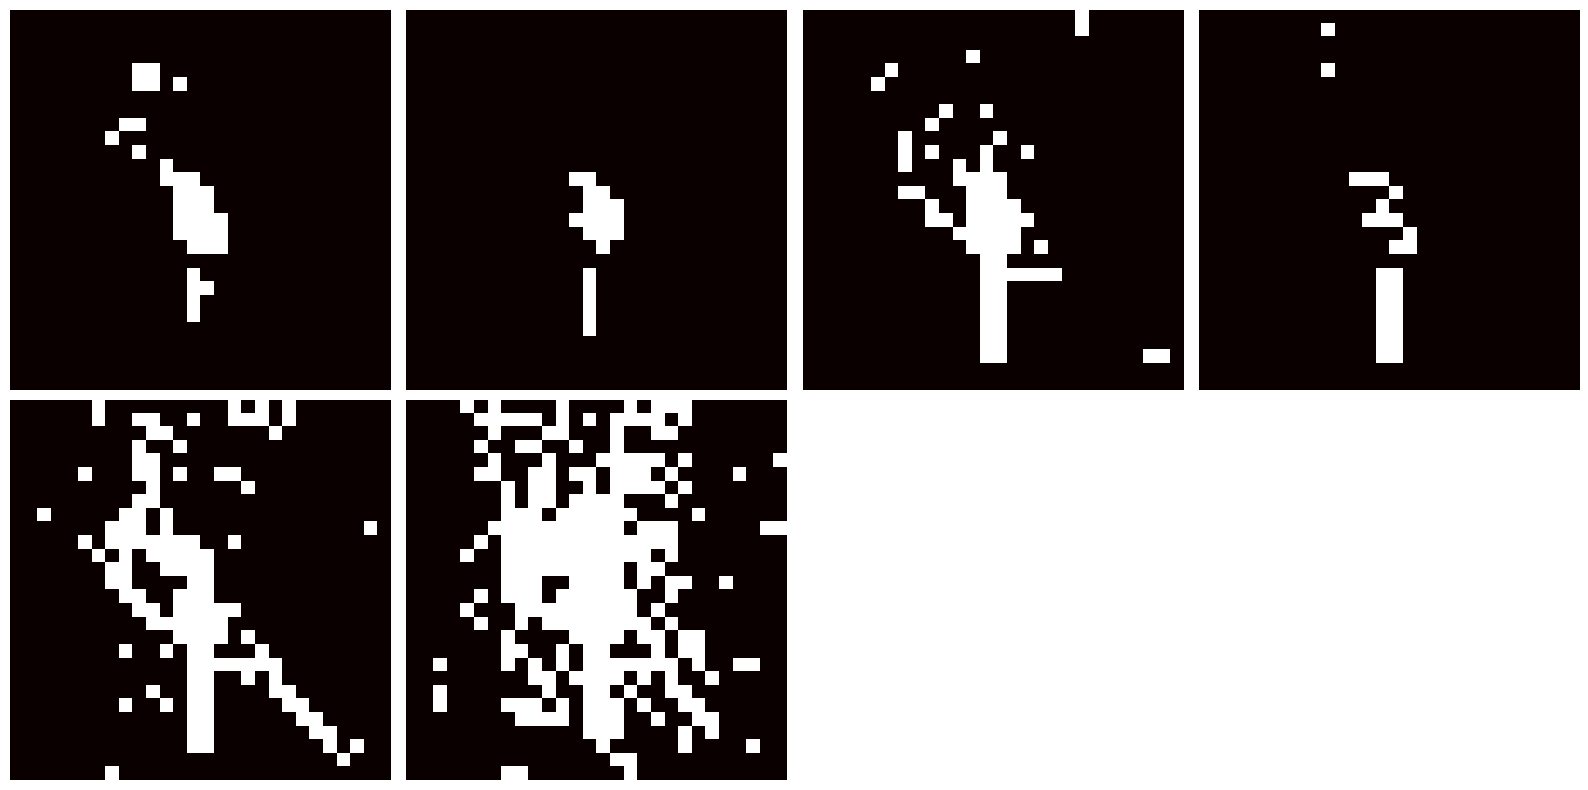

In [43]:
plt.figure(figsize=(16, 8))
for i in range(nh):
    plt.subplot(2, 4, i + 1)
    plt.imshow(th_attn[i], cmap="hot", interpolation="nearest")
    plt.axis("off")
    plt.grid(False)
plt.tight_layout()
plt.show()
